# 8. 인공지능으로 세상에 없던 새로운 패션 만들기 [프로젝트]

GAN을 학습하는 과정은 보기보다 까다롭습니다. 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많습니다.

이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다.

이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

우선 주요 라이브러리 버전을 확인하고 진행합시다.


In [3]:
import tensorflow as tf # tensorflow 모듈을 불러옴
import imageio  # imageio 모듈을 불러옴

print(tensorflow.__version__)  # tensorflow의 버전을 출력
print(imageio.__version__)  # imageio의 버전을 출력

2.13.0
2.31.3


## STEP 1. 작업환경 구성하기

다음과 같이 작업환경을 구성합시다.

In [2]:
! mkdir -p aiffel/dcgan_newimage/cifar10/generated_samples
! mkdir -p aiffel/dcgan_newimage/cifar10/training_checkpoints
! mkdir -p aiffel/dcgan_newimage/cifar10/training_history

## STEP 2. 데이터셋 구성하기

CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.

In [6]:
cifar10 = tf.keras.datasets.cifar10  # cifar10 데이터셋을 불러옴

(train_x, _), (test_x, _) = cifar10.load_data()  # cifar10 데이터셋을 train_x와 test_x로 나눠서 로드

train_x.shape  # train_x의 shape 출력

(50000, 32, 32, 3)

각 픽셀은 0~255 사이의 정숫값을 가지며, 총 60,000개의 컬러이미지 데이터가 있습니다. 이 중 50,000개는 학습용으로, 10,000개는 테스트용으로 사용하도록 하겠습니다.

In [7]:

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


train_x를 정규화

In [8]:
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


첫번째 데이터를 꺼내어 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


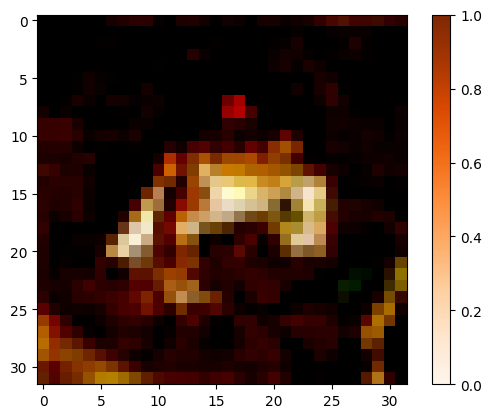

In [19]:
import matplotlib.pyplot as plt  # matplotlib.pyplot 모듈을 불러옴
plt.imshow(train_x[0].reshape(32,32,3), cmap='Oranges')  # train_x[0]을 cmap='gray'로 출력
plt.colorbar()
plt.show()

랜덤한 25개의 데이터를 꺼내어 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

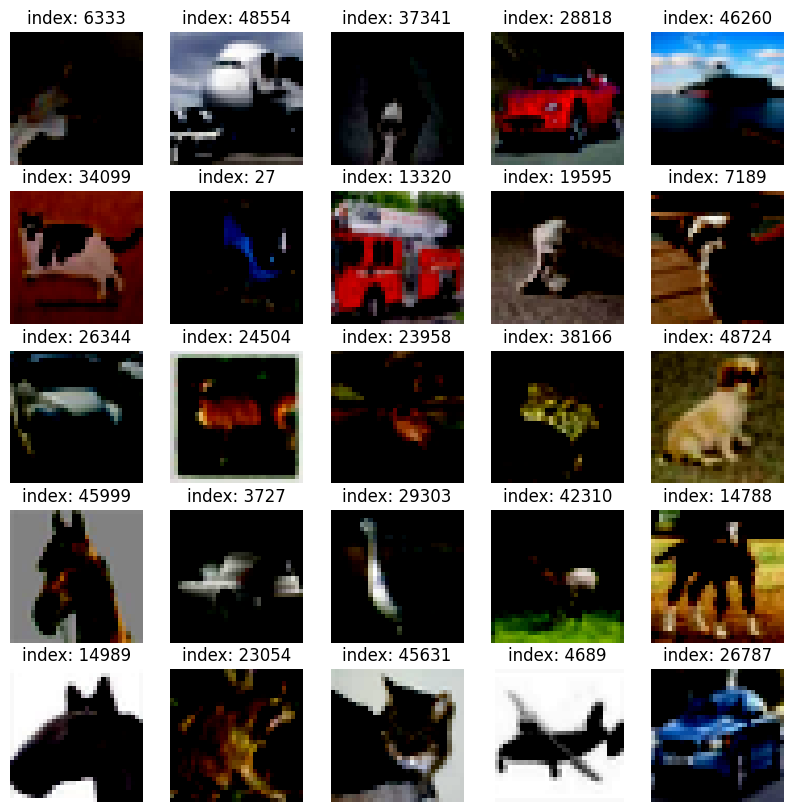

In [24]:
import numpy as np  # numpy 모듈을 불러옴

plt.figure(figsize=(10, 10))

for i in range(25):
    random_index = np.random.randint(1, 50000)
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[random_index].reshape(32, 32, 3), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.


In [25]:
# 전체 데이터를 섞어서 다시 로드
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [26]:
# 미니배치 학습을 위한 데이터셋 구성

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


2023-09-21 01:16:53.446646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-21 01:16:53.461395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-21 01:16:53.461441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-21 01:16:53.462595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-21 01:16:53.462629: I tensorflow/compile

tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있습니다. 위 코드는 train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 합니다. 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋습니다.

## STEP 3. 생성자 모델 구현하기

(32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

세 번의 Conv2DTranspose 층을 이용해 (8, 8, 256) → (16, 16, 64) → (32, 32, 1) 순으로 이미지를 키워나갑니다. 여기서 최종 사이즈인 (32, 32, 1)은 우리가 준비했던 데이터셋과 형상이 동일합니다.

In [27]:
from pyexpat import model
import tensorflow as tf
import keras.layers as layers

def make_generator_model():  # 생성자 모델을 만드는 함수
  # Start
  model = tf.keras.Sequential()
  # First: Dense layer
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  # Second: Reshape layer
  model.add(layers.Reshape((8, 8, 256)))
  
  # Third: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  # Fourth: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  # Fifth: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  
  return model

In [30]:
generator = make_generator_model()

generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_6 (Bat  (None, 16384)             65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 8, 8, 128)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_7 (Bat  (None, 8, 8, 128)        